In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(11)
%matplotlib inline
sns.set()

# Introduction

This project is drawn from a Kaggle competition (ends Aug 29. 2018) to predict loan outcomes.  Here's the official description:

*Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.*

*Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.*

*While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.*

The dataset consists of seven tables: one main table with essential data for every loan example, and six subsidiary tables (e.g., previoius application data) which may or may not have entries for any given loan listed in the main table.  The evaluation criterion is area under the model's ROC curve.

### Challenges
The most obviously formidable challenge in this competition is the dataset, which is medium quantity, mixed type, high opacity, and high sparsity.  Here's what I mean and why these are challenges:
- <b>Medium quantity:</b> at 300K examples and 122 features in the main table alone, the dataset is large enough to impose some computational limits (or at least inconveniences) on our models and processes
- <b>Mixed type:</b> the features are a mix of quantitative, multi-categorical, and binary-categorical.  As most models can only handle quantitative or binary features, we face the choice of dropping features or ballooning dimensionality with dummy columns.
- <b>High opacity:</b> the nature of the data is poorly explained (column descriptions, where extant, are single-clause and non-American English), and we have no information about how it was collected.  This makes cleaning highly problematic.
- <b>High sparsity:</b> the subsidiary tables have entries for some example loans and not for others; and even the primary table with all our example loans is strewn with nulls and zeroes.

In particular, the high opacity and high sparsity in combination means that there will be a lot of guesswork involved in handling our null values.

The predictive modeling will also pose some challenges, but those challenges will be more typical and less specifically anticipable from the nature of the task.

### My approach
I'm going to begin by cleaning up the main table to produce a workable dataset.  I'll then run a few basic models on this dataset to get us an accuracy baseline.  Given the challenges above, the best out-of-box models will probably be the tree-based models from H2O (which are highly optimized and can handle multi-categorical variables directly), especially in combination with GLRM (which can combine quantitative and multi-categorical variables, and impute effectively).

Once we have the accuracy baseline, we can try several methods of leveraging our subsidiary datasets to improve the accuracy of our model.  These may include merging and then imputing, imputing and then merging, imputing and feature-reduction and then merging, or creating separate models for each subsidiary dataset and combining them into an ensemble.

# Load and clean

In [7]:
raw_apps_df = pd.read_csv("application_train.csv")
raw_apps_df.columns = [str.lower(column) for column in raw_apps_df.columns]

In [8]:
apps_df = raw_apps_df.copy()

In [100]:
print(apps.shape)
apps_df.head()

(307511, 122)


,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# convert Y/N to True/False booleans:
apps_df['flag_own_car'] = apps_df.flag_own_car=='Y'
apps_df['flag_own_realty'] = apps_df.flag_own_realty=='Y'
# convert mistyped float/str column:
apps_df['ext_source_1'] = apps_df.ext_source_1.astype(float)

# Manual null handling

We'll try some imputing packages (chiefly GLRM), but first we should make a manual null-less dataset to get a baseline.

### Combine housing columns

The columns describing client housing are numerous (46) and strewn with nulls.  They are all normalized to a 0-to-1 range, with numbers closer to zero representing lower quality or less expensive housing (e.g., small number of rooms, entrances, square feet).

Since many of the nulls represent legitimate zeros (has no basement square footage, or no non-living-rooms, or no home at all), the best solution here is probably to fill the nulls with zeros.  The only clear exception is years_build_medi, which represents the age of the building.  Since zero represents a new building, we should fill nulls with a 0.5 for average age.

We can then combine all housing columns (other than housing age, where 0 is higher quality) into one column that represents the accumulated quality and expensiveness of the housing.  This combination will lose some data, but it will also help wash out the very approximate nature of this null-filling, and will provide a drastic and extremely helpful reduction in dimensionality.

In [10]:
apps_df['housing_age'] = apps_df.years_build_medi.fillna(0.5)
apps_df.drop('years_build_medi', axis=1, inplace=True)

housing_cols = apps_df.columns[44:85]
housing_categoricals = ['fondkapremont_mode', 'housetype_mode', 'wallsmaterial_mode', 'emergencystate_mode']

apps_df['housing_null_count'] = apps_df[housing_cols].isnull().sum(axis=1)
apps_df[housing_cols] = apps_df[housing_cols].fillna(value=0)
apps_df['totalarea_mode'] = apps_df['totalarea_mode'].fillna(value=0) # done separately only because of column ordering
apps_df[housing_categoricals] = apps_df[housing_categoricals].fillna(value='Unknown')
apps_df['housing_quality'] = apps_df[housing_cols].sum(axis=1) + apps_df['totalarea_mode']
apps_df.drop(labels=housing_cols, axis=1, inplace=True)

In [11]:
apps_df['other_null_count'] = apps_df.isnull().sum(axis=1)

### Handle other significant null counts

In [12]:
# nulls for who was with the person when they applied can be 'Unaccompanied'
apps_df['name_type_suite'].fillna(value='Unaccompanied', inplace=True)
# we'll group all void occupation types into 'Other/unemployed' since it's not clear whether the existing category
#'Laborer' means 'Other'
apps_df['occupation_type'].fillna(value='Unemployed/other', inplace=True)
# for vehicle age, we'll say that having no car is like having a really old car
apps_df['own_car_age'].fillna(value=75, inplace=True)
# almost all of the credit bureau call and social circle defaults values are zero (median=0), 
# so we'll impute zeroes for those
for colname in ['amt_req_credit_bureau_hour', 
                'amt_req_credit_bureau_day',
                'amt_req_credit_bureau_week', 
                'amt_req_credit_bureau_mon', 
                'amt_req_credit_bureau_qrt', 
                'amt_req_credit_bureau_year',
                'obs_30_cnt_social_circle',
                'def_30_cnt_social_circle',
                'obs_60_cnt_social_circle',
                'def_60_cnt_social_circle']:
    apps_df[colname].fillna(value=0, inplace=True)
# and for the external data sources we'll just impute the median of 0.5
for colname in ['ext_source_1', 'ext_source_2', 'ext_source_3']:
    apps_df[colname].fillna(value=0.5, inplace=True)
# there are just 278 amt_goods_price nulls; we'll impute the median
apps_df['own_car_age'].fillna(value=450000, inplace=True)
# and we'll drom the 15 other scattered nulls in the dataset
apps_df.dropna(inplace=True)

## Create small dataset

For some of our models, it will be helpful to combine a number of the very sparse rows into combined features in order to reduce dimensionality.

In [13]:
apps_small_df = apps_df.copy()

In [14]:
req_cols = ['amt_req_credit_bureau_hour', 
            'amt_req_credit_bureau_day',
            'amt_req_credit_bureau_week', 
            'amt_req_credit_bureau_mon', 
            'amt_req_credit_bureau_qrt', 
            'amt_req_credit_bureau_year']
apps_small_df['amt_req'] = apps_small_df[req_cols].sum(axis=1)
apps_small_df.drop(req_cols, axis=1, inplace=True)

soc_cols = ['obs_30_cnt_social_circle',
            'def_30_cnt_social_circle',
            'obs_60_cnt_social_circle',
            'def_60_cnt_social_circle']
apps_small_df['soc_cols'] = apps_small_df[soc_cols].sum(axis=1)
apps_small_df.drop(soc_cols, axis=1, inplace=True)

In [15]:
# Only three of the 20 document-submitted-flag columns have more than 10% submission rates.  The rest are very low, 
# mostly single or double digits.  We'll combine these.
docs_to_sum = [col for col in apps_small_df.columns[54:74] if col not in ['flag_document_3', 'flag_document_6', 'flag_document_8']]
apps_small_df['other_docs_submitted'] = apps_small_df[docs_to_sum].sum(axis=1)
apps_small_df.drop(docs_to_sum, axis=1, inplace=True)

In [16]:
print("Small dataset feature count: ", apps_small_df.shape[1])
print("Large dataset feature count: ", apps_df.shape[1])

Small dataset feature count:  59
Large dataset feature count:  84


### Recap
We now have two manually cleaned datasets with no null values: apps_df, the full non-null dataset, and apps_small_df, a reduced dataset with smaller dimensionality.  Both still have some multi-class categorical variables.

# Examining the data

### Outcome distribution

First, let's take a look at our target variable distribution.

In [516]:
apps_df.target.value_counts()

0    282416
1     24804
Name: target, dtype: int64

This is definitely an imbalanced dataset (8% positives), but it's not terribly skewed.  Since it's most important not to give loans that will default, we want to place some priority on catching all defaults, which means eliminating false negatives.  Given this priority, F1-score makes sense as a measure that emphasizes positives identification (it doesn't incorporate true negatives in its formula).

### Core features distribution

Let's take a look at the distributions of income levels, loan amounts, and loan annuities:

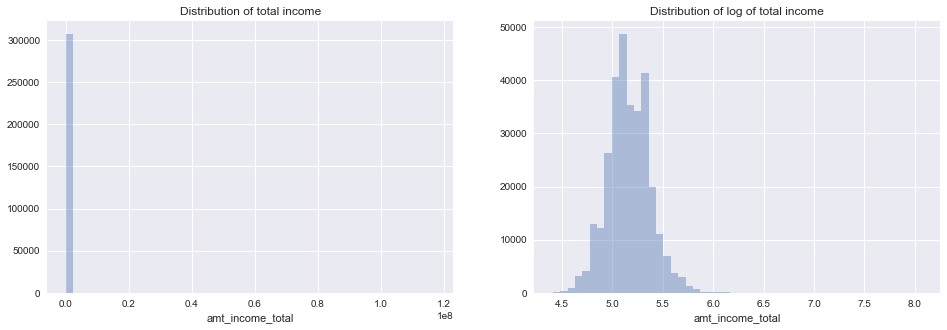

In [518]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(apps_df.amt_income_total, kde=False)
plt.title("Distribution of total income")
plt.subplot(1,2,2)
sns.distplot(np.log10(apps_df.amt_income_total), kde=False)
plt.title("Distribution of log of total income")
plt.show()

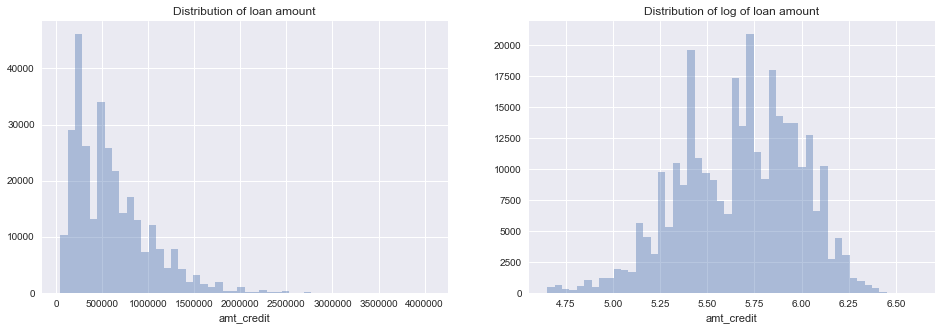

In [519]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(apps_df.amt_credit, kde=False)
plt.title("Distribution of loan amount")
plt.subplot(1,2,2)
sns.distplot(np.log10(apps_df.amt_credit), kde=False)
plt.title("Distribution of log of loan amount")
plt.show()

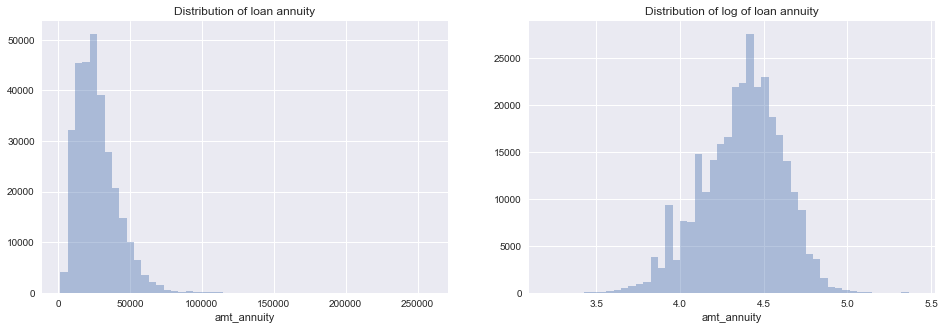

In [520]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(apps_df.amt_annuity, kde=False)
plt.title("Distribution of loan annuity")
plt.subplot(1,2,2)
sns.distplot(np.log10(apps_df.amt_annuity), kde=False)
plt.title("Distribution of log of loan annuity")
plt.show()

For all three of these statistics, a log transform is required to achieve a normal distribution.  Since many models assume normality (or at least work better with normally distributed features), we probably want to apply the log transform to the features in our dataset.  First, though, let's take a look at their scatterplot:

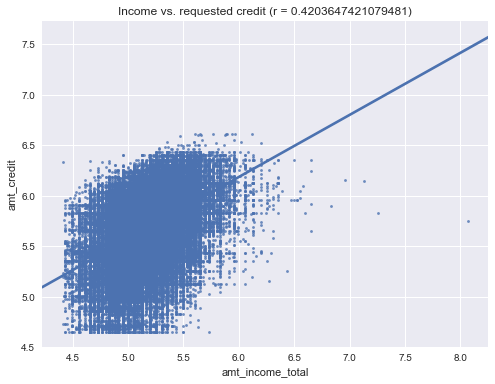

In [425]:
from scipy.stats import pearsonr
plt.figure(figsize=(8,6))
x = np.log10(apps_df.amt_income_total)
y = np.log10(apps_df.amt_credit)
sns.regplot(x,y, scatter_kws={'s':8})
pcc = pearsonr(x,y)[0]
plt.title("Income vs. requested credit (r = {})".format(pcc))
plt.show()

This tells us several things.  First, amount of income and amount of loan are strongly correlated (no surprise therE).  Second, there are a couple large outliers in our dataset where the income amount is over 10 million.  These might be worth eliminating, given that they're likely to be throw off our broader patterns.

Third, we can see that our minima display pretty hard cutoffs.  The smallest loans requested are 45,000 (units unknown); given that there are 230 loan requests of this amount and none of 50,000, it probably represents a minumum amount policy.  The smallest income reported is 25,650 (units unspecified); the income amounts display a more gradual decay toward the minum, however.

Given what we've learned, let's drop our three largest outliers and replace amt_credit and amt_income_total with logs of their values.

In [17]:
apps_df = apps_df[apps_df.amt_income_total < 1e7]
apps_df['amt_credit'] = apps_df['amt_credit'].apply(np.log10)
apps_df['amt_income_total'] = apps_df['amt_income_total'].apply(np.log10)
apps_small_df = apps_small_df[apps_small_df.amt_income_total < 1e7]
apps_small_df['amt_credit'] = apps_small_df['amt_credit'].apply(np.log10)
apps_small_df['amt_income_total'] = apps_small_df['amt_income_total'].apply(np.log10)

Are there differences in these patterns between loans that did vs didn't result in repayment difficulties?

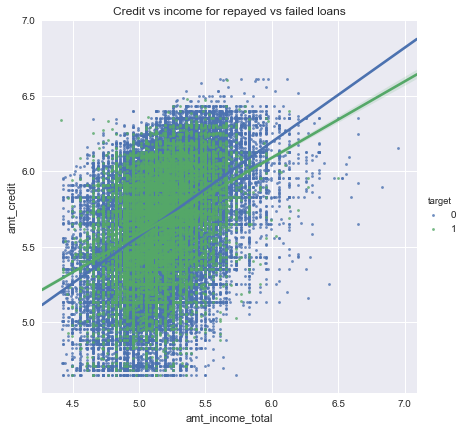

In [526]:
sns.lmplot(x='amt_income_total', y='amt_credit', hue='target', data=apps_df, size=6, scatter_kws={'s':8})
plt.title("Credit vs income for repayed vs failed loans")
plt.show()

Surprisingly, it seems that there's actually a lower correlation between income and loan amount for failed loans than for loans with no repayment problem.  This may be attributable to greater lender caution with higher loan amounts.

### Correlations & redundancies

Now let's take a look at our variable correlations and see if any are too redundant to keep as separate features.

In [ ]:
non_binary_cols = [colname for colname in apps_df.columns if not colname.startswith('flag')]
corr = apps_small_df[non_binary_cols].corr()

# throws super perplexing KeyError!!!
# persists even with non_binary_cols = [colname.replace('\n', '') for colname in apps_df.columns if not colname.startswith('flag')]

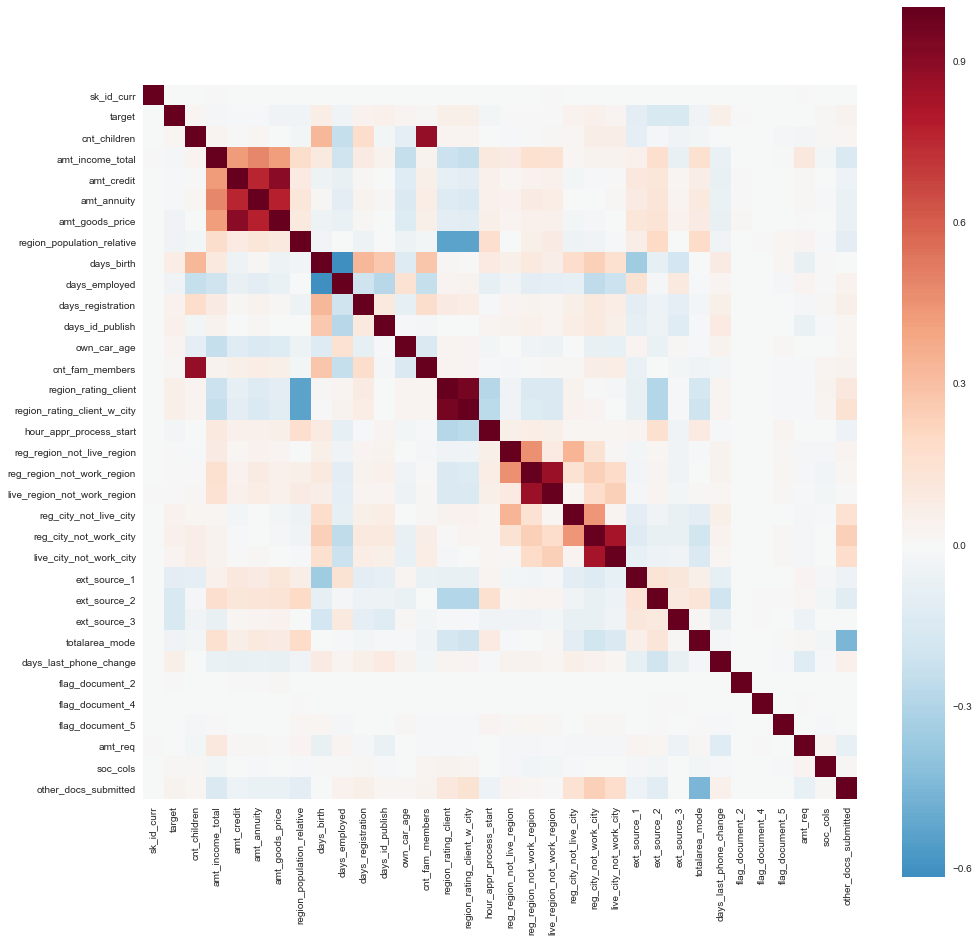

In [499]:
binary_cols = ['flag_own_car', 'flag_own_realty', 'flag_mobil', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email', 'flag_document_3', 'flag_document_6', 'flag_document_8']
corr = apps_small_df.drop(binary_cols, axis=1).corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, square=True, center=0, cmap='RdBu_r');
plt.show()

Based on these correlations, we can remove a few features from our datasets:

In [19]:
redundant_cols = ['amt_goods_price', 
                  'cnt_fam_members', 
                  'region_rating_client_w_city', 
                  'live_region_not_work_region', 
                  'live_city_not_work_city']

apps_df.drop(redundant_cols, axis=1, inplace=True)
apps_small_df.drop(redundant_cols, axis=1, inplace=True)

# Initial models

To get a baseline for performance, let's try four fairly fast models:
- linear regression (with Stochastic Gradient Descent)
- XGboost
- Random Forest
- SVC with kernel approximation (or just linear kernel?)

Because we have a fairly high dimensionality here, we'll also try some dimensionality reduction:
- GLRM + XGboost
- GLRM + Random Forest

First, we'll create a quantitatives-only version of the dataset:

In [20]:
small_categorical_cols = ['name_contract_type',
                          'code_gender',
                          'name_type_suite',
                          'name_education_type',
                          'name_income_type',
                          'name_family_status',
                          'name_housing_type', 
                          'occupation_type',
                          'weekday_appr_process_start',
                          'organization_type',
                          'fondkapremont_mode',
                          'housetype_mode',
                          'wallsmaterial_mode',
                          'emergencystate_mode']

X_quant_df = apps_small_df.drop(small_categorical_cols, axis=1)
Y = apps_df['target']

In [578]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
# sgd = SGDClassifier(loss='hinge', penalty='l1', alpha=0.0001, max_iter=30, random_state=11)

sgd = SGDClassifier(loss='hinge', penalty='l1', alpha=.001, max_iter=25, random_state=11)
np.mean(cross_val_score(sgd, X_quant_df.drop('target', axis=1), Y, cv=3, scoring='f1'))

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.038641797796934274

This is not a good sign: our SGD classifier is not only scoring very low, but it's sometimes failing to predict any positives whatsoever (the f1-score error comes from dividing by zero).  It does this across a wide range of parameters, including various penalty types and alpha values.  This is unusual given a dataset that is almost 8% positives.  It may indicate high nonlinearity.  It certainly indicates that logistic regression is not going to be an effective model here.

In [24]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
np.mean(cross_val_score(rfc, X_quant_df.drop('target', axis=1), Y, cv=3, scoring='f1'))

0.06671617080023749

In [ ]:
FIRST RUN GLRM TO GET GLRM DATASET. THEN try running OOB models (SGD, forest, xgboost, svm?) 
on the GLRM and non-reduced datasets.

## Experimental

In [4]:
# Load the H2O library and start up the H2O cluster locally on your machine
import h2o

# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...


CalledProcessError: Command '['/usr/bin/java', '-version']' returned non-zero exit status 1.

In [18]:
apps.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html